In this blog post, I will use the Seaborn Diamonds dataset to predict the price of a diamond based on various features of that diamond, like color, cut, and depth. Through this exercise, I hope to learn which features of a diamond contribute most to its price. 

# Get and Examine the Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Let's examine the columns and their data types. We will also check for null and missing values. 

In [2]:
diamonds.shape
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [3]:
# Check for any null values. 
diamonds.isna().any().any()

False

Looks like this dataset doesn't contain any null values, so we don't have to interpolate missing values. 

In [4]:
# Let's find the minimum and maximum price for any individual diamond. 
[diamonds['price'].min(), diamonds['price'].max()]

[326, 18823]

It appears the price of the diamonds is in a very large range. The price varies from a couple hundred dollars on the low-end to around $19K on the high end. Let's also examine the other quantitative variables, to ensure they are correct. 

In [5]:
[diamonds['carat'].min(), diamonds['carat'].max()]
[diamonds['depth'].min(), diamonds['depth'].max()]
[diamonds['table'].min(), diamonds['table'].max()]
[diamonds['x'].min(), diamonds['x'].max()]

[0.0, 10.74]

So far, carat, depth, and table seem to have a reasonable range. However, the x-min is 0.0. It is not possible for the x-dimension of the diamond to be zero (otherwise it would be flat), so this seems suspicious. Let's see if the same problem appears for the y and z dimensions. 

In [6]:
[diamonds['y'].min(), diamonds['z'].min()]

[0.0, 0.0]

Indeed, the y and z dimensions also have min values of 0. Let's remove these entries from the dataframe before we do any further processing. 

In [7]:
diamonds = diamonds[(diamonds[['x', 'y', 'z']] != 0).all(axis=1)]
diamonds.shape

(53920, 10)

In [8]:
# Print out the new minimum values for all three variables. 
[diamonds['x'].min(), diamonds['y'].min(), diamonds['z'].min()]

[3.73, 3.68, 1.07]

These new minimum values look much better.  
Let's now get a better sense for the price variability by plotting the diamond price via a histogram. 

<AxesSubplot:xlabel='price', ylabel='Count'>

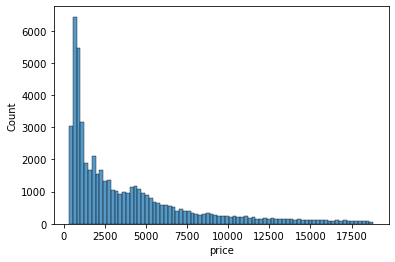

In [9]:
sns.histplot(data=diamonds, x="price")

This visualization gives us further insight into the price of the diamonds. It seems that most of the diamonds are on the low end, but there are a few very expensive diamonds.

Now, let's identify which factors most affect a given diamond's price. First, let's identify what factor the diamond carat (weight) has on price. We can visualize this relationship through a scatterplot. 

<AxesSubplot:xlabel='carat', ylabel='price'>

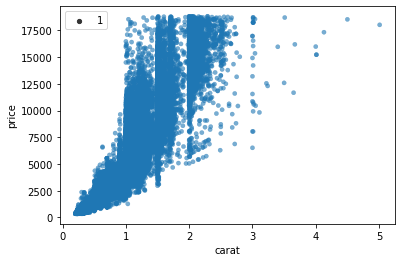

In [10]:
sns.scatterplot(data=diamonds, x="carat", y="price", size=1, alpha=0.6, edgecolor=None)

It seems there is a lot of noise that somewhat degrades the quality of the plot. There is a lot of variation in price, especially for smaller carat values. However, there appears to be a positive relationship between carat value and price. We may, however, need to combine the diamond's weight with other features of the diamond in order to help determine the price. 

Since the linear regression model will be easier to construct with quantitative variables, we will not include the following features of the diamond into our linear model. However, it may be worthwhile to see what impact they have on price. We can first examine how the diamond cut affects price through a bar chart. 

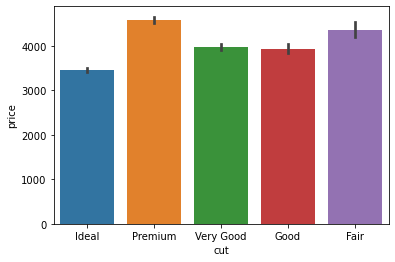

In [11]:
sns.barplot(data=diamonds, x="cut", y="price", palette="tab10");

Interestingly, it appears that the quality of the cut doesn't have much to do with the price. In fact, ideal cuts appear to have the lowest aggregated price. 

Let's also examine if the color of the diamond is a good predictor of price. 

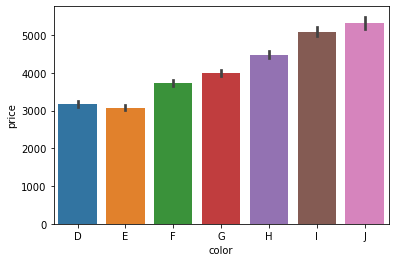

In [12]:
sns.barplot(data=diamonds, x="color", y="price", palette="tab10");

Here, we see that as the color changes from D (worst) to J (best), the price tends to increase. 

# Constructing a Linear Model

Now, we are ready to create a linear model, which will allow us to predict the price of a diamond given its carat, color, clarity, depth, etc. 

First, let's try to predict the price based on just its carat and depth. We can add more variables later, but let's keep it simple for now. We will begin by performing a train-test split. 

In [13]:
from sklearn.model_selection import train_test_split
X = diamonds[["carat", "depth"]]
y = diamonds['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.10, random_state=42)

In [14]:
from sklearn.linear_model import LinearRegression
lin_reg1 = LinearRegression().fit(X_train1, y_train1)
lin_reg1.coef_,lin_reg1.intercept_

(array([7762.28116317, -103.52648711]), 4132.415850047035)

It appears that a diamond's carat value has a strong positive correlation with the diamond's price, while the diamond depth has a negative correlation with price. Let's see how well this linear model predicts the price of samples in the test set. 

In [15]:
y_pred1 = lin_reg1.predict(X_test1)

# Compute the R^2 score for the test set. 
lin_reg1.score(X_test1, y_test1)

0.8616559045890193

Our R^2 score is around 86%, which is pretty good. This metric indicates that most of the variability in the data can be explained by the model. 

Let's also construct a linear model using the diamond's dimensions (x, y, z) as the input variables and price as the output variable. 

In [16]:
X = diamonds[['x', 'y', 'z']]
y = diamonds['price']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.10, random_state=42)

lin_reg2 = LinearRegression().fit(X_train2, y_train2)
lin_reg2.coef_, lin_reg2.intercept_

(array([2789.14417141,  211.45956175,  265.86458654]), -14207.74997306879)

As the dimensions of the diamond increase, its price also tends to increase. This makes intuitive sense, since larger diamonds are probably worth more than smaller diamonds.

Below are the predictions for this second linear model. 

In [17]:
y_pred2 = lin_reg2.predict(X_test2)
lin_reg2.score(X_test2, y_test2)

0.7931234273030509

Again, we get an R^2 score of around 80%. It could be better, but it's certainly not bad. 

# Visualizations of Linear Model

Now, I will present a few visualizations of the diamonds dataset. I will start by plotting the carat and depth values and observing how they affect price. 

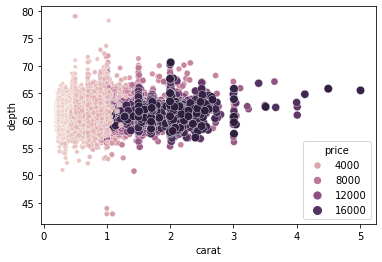

In [18]:
ax = sns.scatterplot(data=diamonds, x="carat", y="depth", hue="price", size="price")

We can immediately see that as the diamond carat increases, the price tends to increase. This can be established due to the darker dots beginning from ~1 carat and extending until ~5 carats. The relationship between depth and price is less apparent. 

Now, let's visualize the relationship between the dimensions of the diamond (x, y, z) and price. We can begin by visualizing the price values between each pair of the diamond's dimensions (e.g. x vs. y, x vs. z, and y vs. z). 

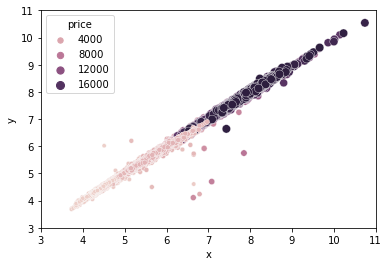

In [19]:
ax = sns.scatterplot(data=diamonds, x="x", y="y", hue="price", size="price")
ax.set_ylim(ymin=3,ymax=11);
ax.set_xlim(xmin=3, xmax=11);

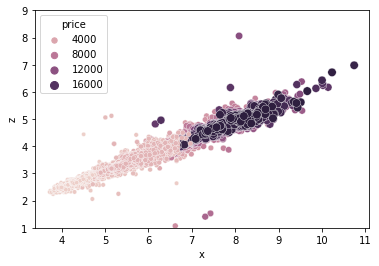

In [20]:
ax = sns.scatterplot(data=diamonds, x="x", y="z", hue="price", size="price")
ax.set_ylim(ymin=1, ymax=9);

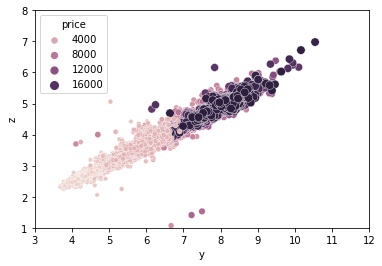

In [21]:
ax = sns.scatterplot(data=diamonds, x="y", y="z", hue="price", size="price")
ax.set_xlim(xmin=3,xmax=12);
ax.set_ylim(ymin=1,ymax=8);

From the three plots above, it appears that as the dimensions of the diamond increase, the price tends to increase as well.

# Constructing a Nonlinear Model

Now let's try using a nonlinear model to predict the diamond price. We can focus on the DecisionTreeRegressor model. To avoid overfitting, let's set the max_depth for this tree to be 2.  

In [22]:
from sklearn.tree import DecisionTreeRegressor

# First, split the data into a train set and a test set. 
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X, y, test_size=0.10, random_state=42)

# Construct the DecisionTreeRegressor model and fit the training data. 
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_train_nl, y_train_nl);

Just like we did with our linear models, let's compute the score for our model and predict the data in the test set. 

In [23]:
y_pred_nl = tree_reg.predict(X_test_nl)
y_pred_nl

array([ 1058.37929498,  6238.89262625, 12311.15592553, ...,
       12311.15592553, 12311.15592553,  3251.84059003])

In [24]:
tree_reg.score(X_test_nl, y_test_nl)

0.8317539986753625

Our decision tree has an R^2 value of around 83%. It looks like it performs similarly to the linear models we previously constructed. 

Now, let's try visualizing our predictions against the true labels. We'll just focus on the first 100 data points in order to make our plot less noisy. 

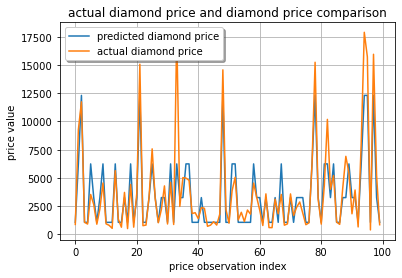

In [25]:
x_data = range(100)
plt.plot(x_data, y_pred_nl[:100], label="predicted diamond price")
plt.plot(x_data, y_test_nl[:100], label="actual diamond price")
plt.title("actual diamond price and diamond price comparison")
plt.xlabel('price observation index')
plt.ylabel('price value')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

It seems that the predicted prices are more or less in the same range as the actual prices. However, it appears that the predictions tend to underestimate the price of expensive diamonds. 

# Attributions

1. https://www.educba.com/seaborn-datasets/
2. https://www.kaggle.com/code/drvader/diamonds-dataset-exploration-and-regression
3. https://github.com/Chinmayrane16/Diamonds-In-Depth-Analysis/blob/master/Diamonds.ipynb
4. https://seaborn.pydata.org/generated/seaborn.scatterplot.html
5. https://www.displayr.com/what-is-overplotting/
6. https://www.geeksforgeeks.org/matplotlib-pyplot-colorbar-function-in-python/
7. https://www.geeksforgeeks.org/3d-scatter-plotting-in-python-using-matplotlib/
8. https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
9. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
10. https://medium.com/the-code-monster/split-a-dataset-into-train-and-test-datasets-using-sk-learn-acc7fd1802e0
11. https://corporatefinanceinstitute.com/resources/data-science/r-squared/
12. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
13. https://www.datatechnotes.com/2020/10/regression-example-with-decisiontreeregressor.html
